# <center>Geometric Methods in Machine Learning<br/><br/>Poincaré Embeddings<br/><br/>Zakarya Ali et Samir Tanfous</center>

Nous étudions l'article [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/pdf/1705.08039.pdf) de Maximilian Nickel et Douwe Kiela.

## Prérequis
On fait l'import du code et des données nécessaires

In [1]:
from collections import defaultdict
import os
import numpy as np
import csv
import random
import time
import pickle
import logger
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
wordnet_mammal_file = 'data/wordnet_mammal_hypernyms.tsv'

In [3]:
def load_wordnet(wordnet_path):
    network = {}
    with open(wordnet_path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            if not row[0]==row[1]:
                if row[0] in network:
                    network[row[0]].append(row[1])
                else:
                    network.update({row[0]:[row[1]]})
    return network

In [4]:
def poincare_dist(gamma): 
    """Distance de Poincaré (équation 1 de l'article)"""
    return np.arccosh(gamma)

In [5]:
def compute_gamma(vec1, vec2):
    euclidean_dists = np.linalg.norm(vec1 - vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    alpha = 1-norm1**2
    beta = 1-norm2**2
    gamma = 1 + 2*euclidean_dists/(alpha*beta)
    return gamma

In [6]:
def deriv_poincare_theta(theta, x, gamma): 
    """Dérivée partielle par rapport à theta de la distance de Poincare (equation 4 de l'article)"""
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
    return 4.0/(beta * np.sqrt(gamma*gamma - 1))*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2))*theta - x/(alpha))

In [7]:
def update(emb, error_, learning_rate):
    """Equation d'update (equation 5)"""
    update =  learning_rate*pow((1 - np.linalg.norm(emb)), 2)*error_/4
    emb = emb - update
    if (np.dot(emb, emb) >= 1):
        emb = emb/np.sqrt(np.dot(emb, emb)) - EPSILON
    return emb

In [8]:
def get_negative_candidates(network, vocab, vocab_weights, u, num_negs):
    """Retourne une liste de mots qui ne sont pas liés à celui donné en entrée"""
    negs = []
    while (len(negs) < num_negs):
        neg = np.random.choice(vocab, p=vocab_weights)
#         neg = random.choice(vocab)
        if not (neg in network[u] or u in network[neg] or neg == u): # neg ne doit pas etre lié à u et vice versa
            negs.append(neg)
    return negs

In [9]:
def initialize_embedding(network, embedding_size):
    """Comme dans l'article, on initialise la position des noeuds entre 0.001 et -0.001"""
    emb = {}
    gap = 1e-3
    for a in network:
        for b in network[a]:
            emb[b] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
        emb[a] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
    return emb

In [10]:
def get_vocabulary(network, embeddings):
    vocab = list(embeddings.keys())
    vocab_weights = np.zeros(len(vocab))
    for key in network:
        for u in network[key]:
            vocab_weights[vocab.index(u)]+=1
    vocab_weights = vocab_weights / np.sum(vocab_weights)
    return vocab, vocab_weights

In [11]:
def plot_poincare_embeddings(emb, epochs, nb_burn_in, num_negs, save=True, show=False):
    fig=plt.figure(figsize=(15,15))
    names = []
    positions_x = []
    positions_y = []
    for key in emb:
        names.append(key)
        positions_x.append(emb[key][0])
        positions_y.append(emb[key][1])

    plt.scatter(positions_x,positions_y, s=1)
    k=1
    plt.text(positions_x[k], positions_y[k], names[k] + " " + str(positions_x[k]), fontsize=10)

    circle = plt.Circle((0, 0), 1, color='g',fill=False)

    plt.axis([-1,1,-1,1])
    ax=fig.add_subplot(1,1,1)
    ax.add_patch(circle)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.title("Poincaré embeddings pour " + str(epochs - nb_burn_in) + " epochs, "
              + str(num_negs) + " negatifs, " 
             + str(nb_burn_in) + " périodes de burn-in")

    if save:
        plt.savefig('poincaré_embeddings_epochs_' + str(epochs - nb_burn_in) + '.png')
    
    if show:
        plt.show()

# 1. Entrainement

In [12]:
#Initialisation des variables
network = load_wordnet(wordnet_mammal_file)

embedding_size = 50 #dimension des vecteurs d'entrainement

#epochs
num_epochs = 1000
#burn-in, nombre d'épochs
nb_burn_in = 10

#nombre de nodes negatives pour l'entrainement
num_negs = 20

#learning rate
lr = 1e-2
#learning rate pour le burn-in
learning_rate_burn_in = lr/10

EPSILON = 1e-5 # evite l'overflow

In [13]:
# random.shuffle(vocab)
emb = initialize_embedding(network, embedding_size)# embedding of nodes of network

vocab, vocab_weights = get_vocabulary(network, emb)

# On ajoute les noeuds non connectés
for a in emb:
    if not a in network:
        network[a] = []
        

last_time = time.time()
loss_stock = np.zeros(num_epochs+nb_burn_in)
for epoch in range(num_epochs+nb_burn_in):
    loss_total = 0
    if epoch < nb_burn_in:
        learning_rate = learning_rate_burn_in
    else:
        learning_rate = lr#/(epoch - nb_burn_in + 1)
    for u in vocab:
        if not network[u]: # une node
            continue
        
        #traitement des positifs
#         positives = random.shuffle(network[u]) 
        v = random.choice(network[u]) 
#         gamma_u_positives = [] # distances entre nodes qui ne sont pas liées
#         dist_positives = [] # distances entre nodes qui ne sont pas liées
#         for v in positives:
        gamma_u_v = compute_gamma(emb[u], emb[v])
#             gamma_u_positives.append(gamma_u_v)
        dist_p_u_v = poincare_dist(gamma_u_v) # distance between the related nodes
#             dist_positives.append(dist_p_u_v)
        
        gamma_u_negs = [] # distances entre nodes qui ne sont pas liées
        dist_negs = [] # distances entre nodes qui ne sont pas liées
        negs = get_negative_candidates(network, vocab, vocab_weights, u, num_negs) 
        for neg in negs:
            gamma_u_neg = compute_gamma(emb[u], emb[neg])
            gamma_u_negs.append(gamma_u_neg)
            dist_neg = poincare_dist(gamma_u_neg)
            dist_negs.append(dist_neg)
                
        loss_den = 0.0
        
        # eqn6
        for dist_neg in dist_negs:
            loss_den += np.exp(-dist_neg)
#         loss = -dist_p_u_v - np.log(loss_den)
        loss = -dist_p_u_v - np.log(loss_den)
        loss_total += loss
    
        
        # derivative of loss wrt positive relation [d(u, v)]
        der_negs = []
        # derivative of loss wrt negative relation [d(u, v')]
        for dist_neg in dist_negs:
            der_negs.append(np.exp(-1*dist_neg)/(loss_den))
        # derivative of loss wrt pos1
        der_p_u = deriv_poincare_theta(emb[u], emb[v], gamma_u_v)
        # derivative of loss wrt pos2
        der_p_v = deriv_poincare_theta(emb[v], emb[u], gamma_u_v)
        
        der_negs_final = []        
        for (der_neg, neg, gamma_u_neg) in list(zip(der_negs, negs, gamma_u_negs)):
            # derivative of loss wrt second element of the pair in neg
            der_neg1 = der_neg * deriv_poincare_theta(emb[neg], emb[u], gamma_u_neg)
            # derivative of loss wrt first element of the pair in neg
            der_neg0 = der_neg * deriv_poincare_theta(emb[u], emb[neg], gamma_u_neg)
            der_negs_final.append([der_neg0, der_neg1])
        
        # update embeddings now
        emb[u] = update(emb[u], der_p_u, learning_rate)
        emb[v] = update(emb[v], der_p_v, learning_rate)
        for (neg, der_neg) in list(zip(negs, der_negs_final)):
            emb[u] = update(emb[u], -1*der_neg[0], learning_rate)
            emb[neg] = update(emb[neg], -1*der_neg[1], learning_rate)
    print('loss_total :', loss_total)
    loss_stock[epoch] = loss_total
    print('Epoch #%d, temps d\'exécution: %.2f seconds' % (epoch + 1, time.time() - last_time))
    if((epoch-nb_burn_in)%50 == 0 and embedding_size == 2):
        plot_poincare_embeddings(emb, epoch, nb_burn_in, num_negs, save=True, show=False)
    last_time = time.time()
pickle.dump(emb, open('data/train.pickle', 'wb'))

loss_total : -3529.72627091
Epoch #1, temps d'exécution: 6.36 seconds
loss_total : -3525.36449494
Epoch #2, temps d'exécution: 6.31 seconds
loss_total : -3523.4334336
Epoch #3, temps d'exécution: 6.34 seconds
loss_total : -3520.67958016
Epoch #4, temps d'exécution: 6.33 seconds
loss_total : -3520.94092223
Epoch #5, temps d'exécution: 6.27 seconds
loss_total : -3519.8261499
Epoch #6, temps d'exécution: 6.31 seconds
loss_total : -3517.78200814
Epoch #7, temps d'exécution: 6.31 seconds
loss_total : -3518.32613668
Epoch #8, temps d'exécution: 6.26 seconds
loss_total : -3515.97799992
Epoch #9, temps d'exécution: 6.37 seconds
loss_total : -3514.37283323
Epoch #10, temps d'exécution: 6.31 seconds
loss_total : -3508.99857864
Epoch #11, temps d'exécution: 6.40 seconds
loss_total : -3492.51940463
Epoch #12, temps d'exécution: 6.27 seconds
loss_total : -3483.95764629
Epoch #13, temps d'exécution: 6.25 seconds
loss_total : -3471.47774222
Epoch #14, temps d'exécution: 6.39 seconds
loss_total : -345

loss_total : -2975.38416218
Epoch #117, temps d'exécution: 6.34 seconds
loss_total : -2938.04933034
Epoch #118, temps d'exécution: 6.31 seconds
loss_total : -2958.77418079
Epoch #119, temps d'exécution: 6.24 seconds
loss_total : -2978.93877275
Epoch #120, temps d'exécution: 6.40 seconds
loss_total : -2968.71840306
Epoch #121, temps d'exécution: 6.32 seconds
loss_total : -2988.90966069
Epoch #122, temps d'exécution: 6.33 seconds
loss_total : -2933.56569879
Epoch #123, temps d'exécution: 6.32 seconds
loss_total : -2963.69592151
Epoch #124, temps d'exécution: 6.34 seconds
loss_total : -2956.9059824
Epoch #125, temps d'exécution: 6.33 seconds
loss_total : -2938.9988099
Epoch #126, temps d'exécution: 6.31 seconds
loss_total : -2926.33849716
Epoch #127, temps d'exécution: 6.29 seconds
loss_total : -2943.13052044
Epoch #128, temps d'exécution: 6.37 seconds
loss_total : -2893.48500377
Epoch #129, temps d'exécution: 6.35 seconds
loss_total : -2902.49208589
Epoch #130, temps d'exécution: 6.29 se

loss_total : -2554.69092486
Epoch #231, temps d'exécution: 6.34 seconds
loss_total : -2541.29179971
Epoch #232, temps d'exécution: 6.35 seconds
loss_total : -2491.10689288
Epoch #233, temps d'exécution: 6.29 seconds
loss_total : -2491.45092216
Epoch #234, temps d'exécution: 6.28 seconds
loss_total : -2499.7970776
Epoch #235, temps d'exécution: 6.33 seconds
loss_total : -2575.27848185
Epoch #236, temps d'exécution: 6.33 seconds
loss_total : -2503.91886957
Epoch #237, temps d'exécution: 6.34 seconds
loss_total : -2525.47701257
Epoch #238, temps d'exécution: 6.25 seconds
loss_total : -2507.58750501
Epoch #239, temps d'exécution: 6.39 seconds
loss_total : -2459.29884343
Epoch #240, temps d'exécution: 6.36 seconds
loss_total : -2465.43156494
Epoch #241, temps d'exécution: 6.29 seconds
loss_total : -2493.12824243
Epoch #242, temps d'exécution: 6.32 seconds
loss_total : -2456.0126417
Epoch #243, temps d'exécution: 6.34 seconds
loss_total : -2422.14586854
Epoch #244, temps d'exécution: 6.42 se

loss_total : -2124.58659173
Epoch #345, temps d'exécution: 6.29 seconds
loss_total : -2022.50787364
Epoch #346, temps d'exécution: 6.31 seconds
loss_total : -2104.14435992
Epoch #347, temps d'exécution: 6.35 seconds
loss_total : -2031.16947835
Epoch #348, temps d'exécution: 6.32 seconds
loss_total : -2130.57449888
Epoch #349, temps d'exécution: 6.32 seconds
loss_total : -2036.53066846
Epoch #350, temps d'exécution: 6.29 seconds
loss_total : -2049.389338
Epoch #351, temps d'exécution: 6.26 seconds
loss_total : -1977.58810496
Epoch #352, temps d'exécution: 6.35 seconds
loss_total : -2082.62808534
Epoch #353, temps d'exécution: 6.38 seconds
loss_total : -2055.91063603
Epoch #354, temps d'exécution: 6.34 seconds
loss_total : -2020.93905929
Epoch #355, temps d'exécution: 6.32 seconds
loss_total : -2053.65072985
Epoch #356, temps d'exécution: 6.32 seconds
loss_total : -2067.79930964
Epoch #357, temps d'exécution: 6.32 seconds
loss_total : -1982.66171713
Epoch #358, temps d'exécution: 6.25 se

loss_total : -1660.82343008
Epoch #459, temps d'exécution: 7.09 seconds
loss_total : -1584.06574101
Epoch #460, temps d'exécution: 7.07 seconds
loss_total : -1554.68170143
Epoch #461, temps d'exécution: 7.12 seconds
loss_total : -1554.91232489
Epoch #462, temps d'exécution: 7.14 seconds
loss_total : -1556.6542887
Epoch #463, temps d'exécution: 7.07 seconds
loss_total : -1535.75710577
Epoch #464, temps d'exécution: 7.11 seconds
loss_total : -1563.10855248
Epoch #465, temps d'exécution: 7.12 seconds
loss_total : -1469.23725487
Epoch #466, temps d'exécution: 7.12 seconds
loss_total : -1541.84025852
Epoch #467, temps d'exécution: 7.08 seconds
loss_total : -1515.20977963
Epoch #468, temps d'exécution: 7.07 seconds
loss_total : -1526.4316052
Epoch #469, temps d'exécution: 7.07 seconds
loss_total : -1598.76797433
Epoch #470, temps d'exécution: 6.49 seconds
loss_total : -1482.80050745
Epoch #471, temps d'exécution: 6.36 seconds
loss_total : -1575.64659133
Epoch #472, temps d'exécution: 6.37 se

loss_total : -1171.97715218
Epoch #573, temps d'exécution: 6.31 seconds
loss_total : -1126.17411859
Epoch #574, temps d'exécution: 6.30 seconds
loss_total : -1173.02958572
Epoch #575, temps d'exécution: 6.30 seconds
loss_total : -965.745506682
Epoch #576, temps d'exécution: 6.32 seconds
loss_total : -942.630417838
Epoch #577, temps d'exécution: 6.32 seconds
loss_total : -980.474568182
Epoch #578, temps d'exécution: 6.32 seconds
loss_total : -909.723899958
Epoch #579, temps d'exécution: 6.34 seconds
loss_total : -981.722481769
Epoch #580, temps d'exécution: 6.36 seconds
loss_total : -989.424529555
Epoch #581, temps d'exécution: 6.32 seconds
loss_total : -986.903891689
Epoch #582, temps d'exécution: 6.35 seconds
loss_total : -982.134753054
Epoch #583, temps d'exécution: 6.37 seconds
loss_total : -989.345058437
Epoch #584, temps d'exécution: 6.35 seconds
loss_total : -954.318270399
Epoch #585, temps d'exécution: 6.38 seconds
loss_total : -944.64615399
Epoch #586, temps d'exécution: 6.33 s

loss_total : -382.506223235
Epoch #687, temps d'exécution: 6.29 seconds
loss_total : -449.764045642
Epoch #688, temps d'exécution: 6.30 seconds
loss_total : -629.289944145
Epoch #689, temps d'exécution: 6.33 seconds
loss_total : -490.624594387
Epoch #690, temps d'exécution: 6.28 seconds
loss_total : -448.945325285
Epoch #691, temps d'exécution: 6.28 seconds
loss_total : -464.153320802
Epoch #692, temps d'exécution: 6.29 seconds
loss_total : -544.94644206
Epoch #693, temps d'exécution: 6.36 seconds
loss_total : -681.511914107
Epoch #694, temps d'exécution: 6.37 seconds
loss_total : -485.004527919
Epoch #695, temps d'exécution: 6.31 seconds
loss_total : -394.083430666
Epoch #696, temps d'exécution: 6.31 seconds
loss_total : -502.339299259
Epoch #697, temps d'exécution: 6.32 seconds
loss_total : -394.26158167
Epoch #698, temps d'exécution: 6.29 seconds
loss_total : -521.463733501
Epoch #699, temps d'exécution: 6.30 seconds
loss_total : -572.878679725
Epoch #700, temps d'exécution: 6.32 se

loss_total : 76.3675365746
Epoch #802, temps d'exécution: 6.30 seconds
loss_total : 17.1142085317
Epoch #803, temps d'exécution: 6.30 seconds
loss_total : 181.589176237
Epoch #804, temps d'exécution: 6.32 seconds
loss_total : -71.5746425798
Epoch #805, temps d'exécution: 6.31 seconds
loss_total : -98.6640652539
Epoch #806, temps d'exécution: 6.28 seconds
loss_total : 27.8826900284
Epoch #807, temps d'exécution: 6.29 seconds
loss_total : -56.3056180437
Epoch #808, temps d'exécution: 6.24 seconds
loss_total : 85.9783725808
Epoch #809, temps d'exécution: 6.36 seconds
loss_total : -15.0768287795
Epoch #810, temps d'exécution: 6.33 seconds
loss_total : 5.50840002086
Epoch #811, temps d'exécution: 6.31 seconds
loss_total : 137.517808846
Epoch #812, temps d'exécution: 6.36 seconds
loss_total : 64.9078887448
Epoch #813, temps d'exécution: 6.32 seconds
loss_total : 6.85736860709
Epoch #814, temps d'exécution: 6.31 seconds
loss_total : 298.374260062
Epoch #815, temps d'exécution: 6.33 seconds
lo

loss_total : 526.780800221
Epoch #918, temps d'exécution: 6.30 seconds
loss_total : 584.977347411
Epoch #919, temps d'exécution: 6.30 seconds
loss_total : 563.327706872
Epoch #920, temps d'exécution: 6.31 seconds
loss_total : 561.174108364
Epoch #921, temps d'exécution: 6.29 seconds
loss_total : 640.721142602
Epoch #922, temps d'exécution: 6.27 seconds
loss_total : 661.003834321
Epoch #923, temps d'exécution: 6.31 seconds
loss_total : 523.780108626
Epoch #924, temps d'exécution: 6.31 seconds
loss_total : 429.604566408
Epoch #925, temps d'exécution: 6.34 seconds
loss_total : 636.157654328
Epoch #926, temps d'exécution: 6.29 seconds
loss_total : 471.827419581
Epoch #927, temps d'exécution: 6.28 seconds
loss_total : 519.309694864
Epoch #928, temps d'exécution: 6.32 seconds
loss_total : 618.557964449
Epoch #929, temps d'exécution: 6.35 seconds
loss_total : 821.889875506
Epoch #930, temps d'exécution: 6.25 seconds
loss_total : 600.235673942
Epoch #931, temps d'exécution: 6.27 seconds
loss_t

# 2. Résultats

### 2.1 Taxinomie

### 2.2 Word Reconstruction

In [14]:
def evaluate_mean_rank_and_map(vocab, network, embeddings, max_n=None):
    """Evalue le mean rank et le MAP pour la reconstruction."""
    ranks = []
    avg_precision_scores = []
    for i, item in list(enumerate(vocab, start=0)):
        if item not in network or item == "mammal.n.01":
            continue
        item_relations = []
        temp = list(embeddings.keys())
        for relation in network[item]:
            item_relations.append(temp.index(relation))
            
        item_distances = all_distances_to(item, embeddings)
#         print("item", item)
        positive_relation_ranks, avg_precision = \
            get_positive_relation_ranks_and_avg_prec(item_distances, item_relations)
        ranks += positive_relation_ranks
        avg_precision_scores.append(avg_precision)
        if max_n is not None and i > max_n:
            break
    return np.mean(ranks), np.mean(avg_precision_scores)

def all_distances_to(item, embeddings):
    """Retourne une liste des distances d'un mot avec tous les autres"""
    all_distances=np.zeros(len(list(embeddings.keys())))
    
    for i, elem in list(enumerate(embeddings)):
        gamma = compute_gamma(embeddings[item], embeddings[elem])
        distance = poincare_dist(gamma)
        all_distances[i]=distance
    return all_distances
    
def get_positive_relation_ranks_and_avg_prec(all_distances, positive_relations):
    positive_relation_distances = all_distances[positive_relations]
    negative_relation_distances = np.ma.array(all_distances, mask=False)
    negative_relation_distances.mask[positive_relations] = True
    # Compute how many negative relation distances are less than each positive relation distance, plus 1 for rank
    ranks = (negative_relation_distances < positive_relation_distances[:, np.newaxis]).sum(axis=1) + 1
    map_ranks = np.sort(ranks) + np.arange(len(ranks))
    avg_precision = ((np.arange(1, len(map_ranks) + 1) / np.sort(map_ranks)).mean())
    return list(ranks), avg_precision

In [15]:
mean_rank, map_ = evaluate_mean_rank_and_map(vocab, network, emb)

In [16]:
print('WordNet reconstruction')
print('Paramètres :')
print('Période de burn-in =', nb_burn_in)
print("Epochs =", num_epochs)
print("Learning rate =", lr)
print("Burn-in learning rate =", learning_rate_burn_in)
print("Dimension =", embedding_size)
print("un nombre de nodes négatives de", num_negs)
print("epsilon =", EPSILON)
print()
print("Résultats :")
print('Mean Rank =', mean_rank, "\nMAP =", map_)

WordNet reconstruction
Paramètres :
Période de burn-in = 10
Epochs = 1000
Learning rate = 0.01
Burn-in learning rate = 0.001
Dimension = 50
un nombre de nodes négatives de 20
epsilon = 1e-05

Résultats :
Mean Rank = 707.340721492 
MAP = 0.0298889734056


### 2.3 Link Prediction

In [17]:
def get_root_and_leaf_nodes(data_file):
    """Return keys of root and leaf nodes from a file with transitive closure relations"""
    root_candidates = set()
    leaf_candidates = set()
    with open(data_file, 'rb') as f:
        for line in f:
            nodes = line.split()
            root_candidates.update(nodes)
            leaf_candidates.update(nodes)
    
    with open(data_file, 'rb') as f:
        for line in f:
            node_1, node_2 = line.split()
            if node_1 == node_2:
                continue
            leaf_candidates.discard(node_1)
            root_candidates.discard(node_2)
    
    return (leaf_candidates, root_candidates)

In [18]:
def train_test_split(data_file, test_ratio=0.1):
    train_filename = data_file + '.train'
    test_filename = data_file + '.test'
    if os.path.exists(train_filename) and os.path.exists(test_filename):
        return (train_filename, test_filename)
    root_nodes, leaf_nodes = get_root_and_leaf_nodes(data_file)
    test_line_candidates = []
    line_count = 0
    all_nodes = set()
    with open(data_file, 'rb') as f:
        for i, line in list(enumerate(f)):
            node_1, node_2 = line.split()
            all_nodes.update([node_1, node_2])
            if (
                    node_1 not in leaf_nodes
                    and node_2 not in leaf_nodes
                    and node_1 not in root_nodes
                    and node_2 not in root_nodes
                    and node_1 != node_2
                ):
                test_line_candidates.append(i)
            line_count += 1

    num_test_lines = int(test_ratio * line_count)
    test_line_indices = set(random.sample(test_line_candidates, num_test_lines))
    train_line_indices = set(l for l in range(line_count) if l not in test_line_indices)
    
    train_set_nodes = set()
    with open(data_file, 'rb') as f:
        train_file = open(train_filename, 'wb')
        test_file = open(test_filename, 'wb')
        for i, line in list(enumerate(f)):
            if i in train_line_indices:
                train_set_nodes.update(line.split())
                train_file.write(line)
            elif i in test_line_indices:
                test_file.write(line)
        train_file.close()
        test_file.close()
    assert len(train_set_nodes) == len(all_nodes), 'Not all nodes from dataset present in train set relations'
    return (train_filename, test_filename)

In [19]:
def get_unknown_relation_ranks_and_avg_prec(all_distances, unknown_relations, known_relations):
    unknown_relation_distances = all_distances[unknown_relations]
    negative_relation_distances = np.ma.array(all_distances, mask=False)
    negative_relation_distances.mask[unknown_relations] = True
    negative_relation_distances.mask[known_relations] = True
    # Compute how many negative relation distances are less than each unknown relation distance, plus 1 for rank
    ranks = (negative_relation_distances < unknown_relation_distances[:, np.newaxis]).sum(axis=1) + 1
    map_ranks = np.sort(ranks) + np.arange(len(ranks))
    avg_precision = ((np.arange(1, len(map_ranks) + 1) / np.sort(map_ranks)).mean())
    return list(ranks), avg_precision

In [20]:
def evaluate_mean_rank_and_map_prediction(vocab, embeddings, items, relations, max_n=None):
    """Evaluate mean rank and MAP for link prediction."""
    ranks = []
    avg_precision_scores = []
    for i, item in list(enumerate(items, start=0)):
        if item not in relations['unknown'] or item == "mammal.n.01":  # No positive relations to predict for this node
            continue
        unknown_relations = []
        for elem in list(relations['unknown'][item]):
            unknown_relations.append(vocab.index(elem))
        known_relations = []
        for elem in list(relations['known'][item]):
            known_relations.append(vocab.index(elem))
        
        item_distances = all_distances_to(item, embeddings)
        unknown_relation_ranks, avg_precision = \
            get_unknown_relation_ranks_and_avg_prec(item_distances, unknown_relations, known_relations)
        ranks += unknown_relation_ranks
        avg_precision_scores.append(avg_precision)
        if max_n is not None and i > max_n:
            break
    return np.mean(ranks), np.mean(avg_precision_scores)

In [21]:
train_filename, test_filename = train_test_split('data/wordnet_mammal_hypernyms.tsv', test_ratio=0.1)

In [22]:
relations = {'known': defaultdict(set), 'unknown': defaultdict(set)}
data_files = {'known': train_filename, 'unknown': test_filename}

In [23]:
items = set()
for relation_type, data_file in data_files.items():
    with open(data_file, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            relations[relation_type][row[0]].add(row[1])
            items.update([row[0], row[1]])

In [24]:
mean_rank, map_ = evaluate_mean_rank_and_map_prediction(vocab, emb, items, relations)

In [25]:
print('Link prediction')
print('Paramètres :')
print('Période de burn-in =', nb_burn_in)
print("Epochs =", num_epochs)
print("Learning rate =", lr)
print("Burn-in learning rate =", learning_rate_burn_in)
print("Dimension =", embedding_size)
print("un nombre de nodes négatives de", num_negs)
print("epsilon =", EPSILON)
print()
print("Résultats :")
print('Mean Rank =', mean_rank, "\nMAP =", map_)

Link prediction
Paramètres :
Période de burn-in = 10
Epochs = 1000
Learning rate = 0.01
Burn-in learning rate = 0.001
Dimension = 50
un nombre de nodes négatives de 20
epsilon = 1e-05

Résultats :
Mean Rank = 812.668393782 
MAP = 0.0325941578882


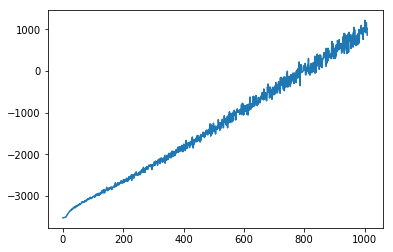

In [26]:
plt.plot(loss_stock)